In [2]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d
import random

from compression_nn.preprocess import prepare_data_for_training


import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [4]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 400
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [5]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [6]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

# Process data; with ZCA whitening

In [7]:
idx_wph_3rd = range(-32-256-160, -32)


dv[:,idx_wph_3rd] = dv[:,idx_wph_3rd]*1e3

dv_LFI[:,idx_wph_3rd] = dv_LFI[:,idx_wph_3rd]*1e3

In [8]:
# no normalization

# train only on OMM and S8
pars_train = pars_train[:, 0:2]
pars_LFI = pars_LFI[:, 0:2]

In [9]:
num_samples = len(pars_train)
# split the sample for training ----------
train_split, val_split = int(0.9*num_samples), int(0.1*num_samples)


In [10]:
# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[:train_split],
    train_y=pars_train[:train_split],
    val_x=dv[train_split:],
    val_y=pars_train[train_split:],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

In [11]:
# plot un-whitened data (test-set)


test_dvs = test_loader.dataset.tensors[0].numpy() # not whitened

train_dvs = train_loader.dataset.tensors[0].numpy() # ZCA whitened

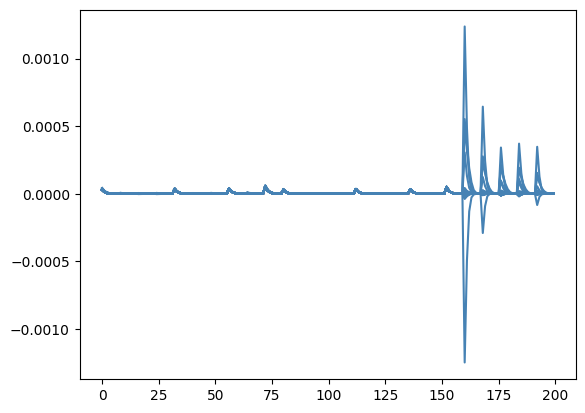

In [12]:
rnd_idx = random.sample(range(300), 100)

for i in rnd_idx:
    plt.plot(test_dvs[i][0:200], color='steelblue')
    

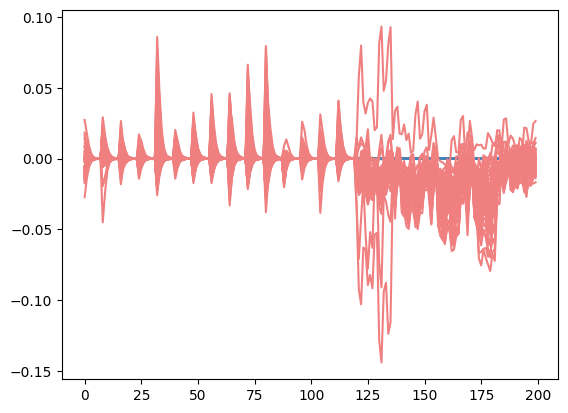

In [13]:
rnd_idx = random.sample(range(300), 100)

for i in rnd_idx:
    plt.plot(test_dvs[i][200:400], color='steelblue')
    
rnd_idx = random.sample(range(300), 100)

for i in rnd_idx:
    plt.plot(train_dvs[i][200:400], color='lightcoral')

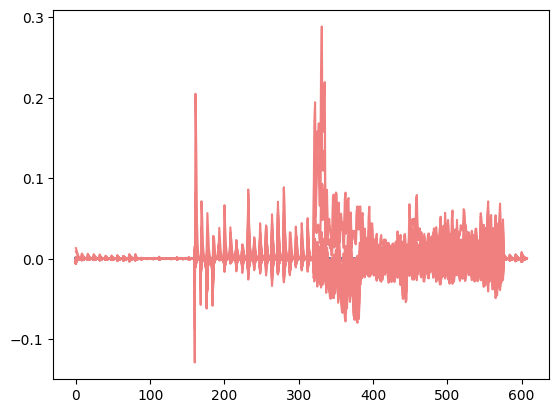

In [14]:
rnd_idx = random.sample(range(300), 100)

for i in rnd_idx:
    plt.plot(test_dvs[i], color='steelblue')
    
rnd_idx = random.sample(range(300), 100)
for i in rnd_idx:
    plt.plot(train_dvs[i], color='lightcoral')

In [17]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

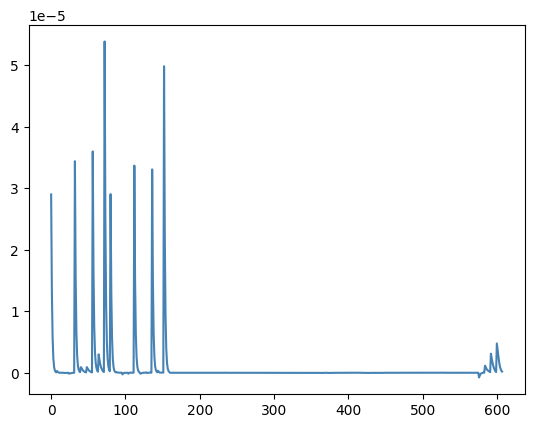

In [19]:
plt.plot(dv[0], color='steelblue')

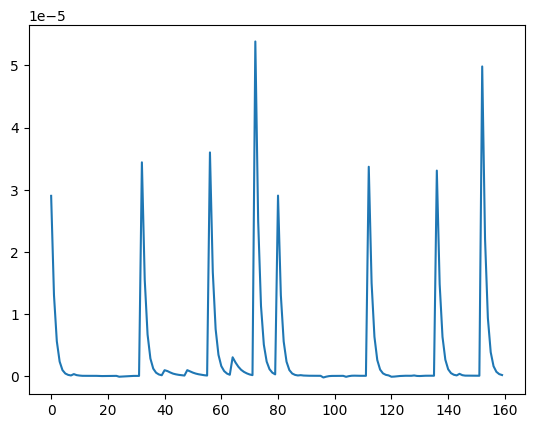

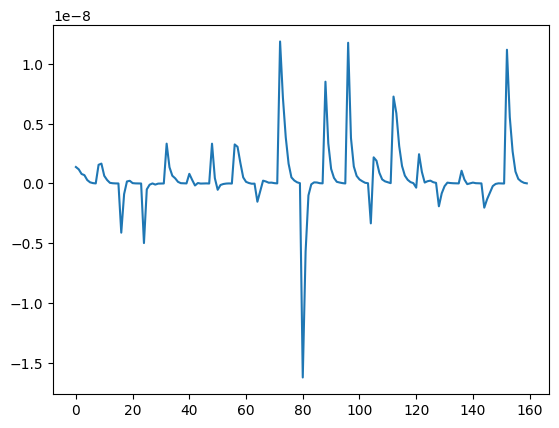

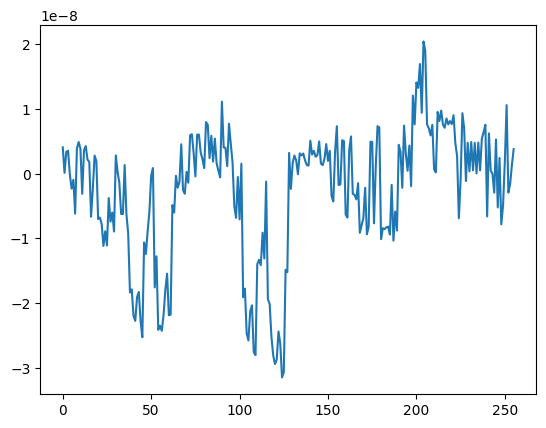

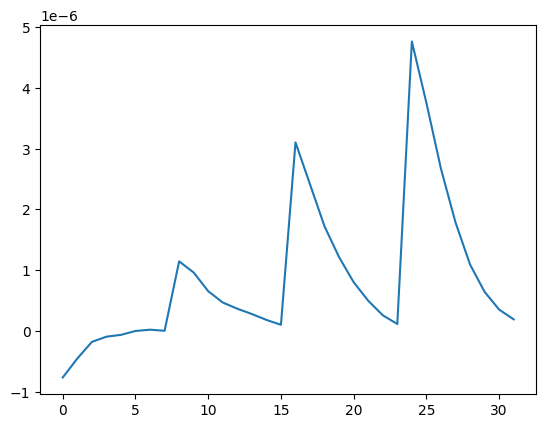

In [22]:
plt.plot(dv[0][0:160])
plt.show()

plt.plot(dv[0][160:320])
plt.show()

plt.plot(dv[0][320:320+256])
plt.show()

plt.plot(dv[0][320+256:])